In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

import sys
sys.path.append("..") 

import p2v

In [2]:
model = p2v.P2V()

2023-11-11 14:28:09 -- start loading Mag_venue_info_df
2023-11-11 14:28:09 -- finish.
2023-11-11 14:28:09 -- start loading labeled_journal_info_df
2023-11-11 14:28:09 -- finish.


In [3]:
periods = [('1950', '1959'), ('1960', '1969'), ('1970', '1979'), ('1980', '1989'), ('1990', '1999'), ('2000', '2009'), ('2010', '2021')]
wv_models = [model.load_wv(b, e, 100, 10) for b, e in periods]
len(wv_models)

2023-11-11 14:28:42 -- start loading word vectors...
2023-11-11 14:28:42 -- word vectors loaded, and its shape is: (1645, 100)
2023-11-11 14:28:42 -- start loading word vectors...
2023-11-11 14:28:42 -- word vectors loaded, and its shape is: (3116, 100)
2023-11-11 14:28:42 -- start loading word vectors...
2023-11-11 14:28:42 -- word vectors loaded, and its shape is: (5686, 100)
2023-11-11 14:28:42 -- start loading word vectors...
2023-11-11 14:28:42 -- word vectors loaded, and its shape is: (9337, 100)
2023-11-11 14:28:42 -- start loading word vectors...
2023-11-11 14:28:42 -- word vectors loaded, and its shape is: (15019, 100)
2023-11-11 14:28:42 -- start loading word vectors...
2023-11-11 14:28:42 -- word vectors loaded, and its shape is: (27460, 100)
2023-11-11 14:28:42 -- start loading word vectors...
2023-11-11 14:28:42 -- word vectors loaded, and its shape is: (37594, 100)


7

In [35]:
vids = set()
for m in wv_models:
    vids.update(m.index_to_key)
len(vids)

43603

In [36]:
0 in vids

True

In [82]:
def get_venue_semantic_change():
    """"""
    alignment = []
    result = []
    for i in range(0, len(wv_models)-1):
        source_model = wv_models[i]
        target_model = wv_models[i+1]

        source_vids = source_model.index_to_key
        target_vids = target_model.index_to_key
        shared_vids = list(set(source_vids) & set(target_vids))
        print(len(shared_vids))

        source_idx = [source_model.get_index(v) for v in shared_vids]
        target_idx = [target_model.get_index(v) for v in shared_vids]

        source_vectors = source_model.get_normed_vectors()[source_idx]
        target_vectors = target_model.get_normed_vectors()[target_idx]

        R, sca = orthogonal_procrustes(source_vectors, target_vectors)
        aligned_source_vectors = np.dot(source_vectors, R)
        alignment.append((aligned_source_vectors, R))

        dist = paired_distances(aligned_source_vectors, target_vectors, metric='cosine')
        change = dict(zip([str(int(v)) for v in shared_vids], dist))
        result.append(change)
    vid_name = {str(k): v for k, v in model.MAG_venue_info_df.OriginalVenue.to_dict().items()}
    vids = set().union(*[list(d.keys()) for d in result])
    rows = []
    for v in vids:
        row = [v, vid_name[v]]
        row.extend(d.get(v, np.nan) for d in result)
        rows.append(row)
    df = pd.DataFrame(rows, columns=['vid', 'name']+['cos_dist_'+periods[i][0]+'s' for i in range(0, len(wv_models)-1)])
    return df, alignment

vid_dist_df, alignment = get_venue_semantic_change()
vid_dist_df.shape

1500
2809
5144
8436
13405
24250


(27048, 8)

In [83]:
vid_dist_df[vid_dist_df.name == 'Nature']

,vid,name,cos_dist_1950s,cos_dist_1960s,cos_dist_1970s,cos_dist_1980s,cos_dist_1990s,cos_dist_2000s
394,137773608,Nature,0.141203,0.18624,0.156809,0.165275,0.179417,0.191892


In [ ]:
def get_first_decade(row):
    """"""
    if row[2]

In [108]:
vid_dist_df.drop(columns=['total', 'max_dist'], inplace=True)

In [109]:
vid_dist_df['max_dist'] = vid_dist_df[['cos_dist_1950s', 'cos_dist_1960s', 'cos_dist_1970s', 'cos_dist_1980s', 'cos_dist_1990s', 'cos_dist_2000s']].max(axis=1)

In [110]:
vid_dist_df['total_dist'] = vid_dist_df[['cos_dist_1950s', 'cos_dist_1960s', 'cos_dist_1970s', 'cos_dist_1980s', 'cos_dist_1990s', 'cos_dist_2000s']].sum(axis=1)

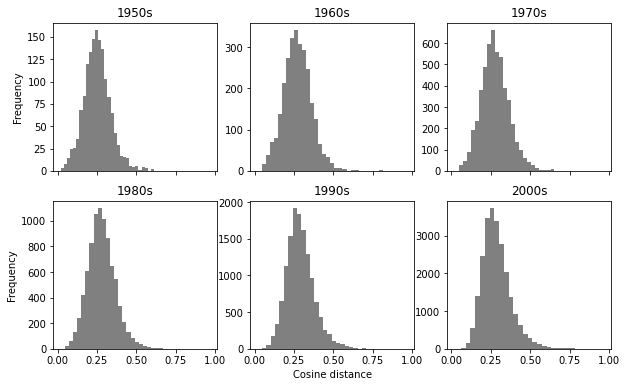

In [236]:
decade_cols = ['cos_dist_1950s', 'cos_dist_1960s', 'cos_dist_1970s', 'cos_dist_1980s', 'cos_dist_1990s', 'cos_dist_2000s']
def plot_distance_distribution(save=False):
    """"""
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(10,6))
    for c, ax in zip(decade_cols, axes.flatten()):
        vid_dist_df[c].plot.hist(ax=ax, bins=30, color='0.5')
        ax.set_title(c[-5:])
    axes[1,1].set(xlabel='Cosine distance')
    for j in [1,2]:
        axes[0,j].set(ylabel='')
        axes[1,j].set(ylabel='')
    if save:
        plt.savefig('../figs/jnl_aligned_dist_hist.pdf', bbox_inches='tight')

plot_distance_distribution(True)

In [238]:
vid_dist_df.sort_values('total_dist', ascending=False)[:10]

,vid,name,cos_dist_1950s,cos_dist_1960s,cos_dist_1970s,cos_dist_1980s,cos_dist_1990s,cos_dist_2000s,max_dist,total_dist,z_cos_dist_1950s,z_cos_dist_1960s,z_cos_dist_1970s,z_cos_dist_1980s,z_cos_dist_1990s,z_cos_dist_2000s
17655,203291325,American Scientist,0.601703,0.583388,0.564318,0.613295,0.628166,0.565060,0.628166,3.555930,4.183176,3.549811,3.258641,3.816813,3.891069,3.013447
21513,196862746,Biographical Memoirs of Fellows of the Royal S...,0.403270,0.497840,0.633888,0.658773,0.537014,0.708058,0.708058,3.438844,1.815264,2.574641,4.046862,4.338125,2.841799,4.565569
10601,65315170,Endeavour,0.571602,0.633583,0.534574,0.478185,0.585333,0.423860,0.633583,3.227137,3.823980,4.121981,2.921639,2.268090,3.398006,1.480843
9230,169320561,Scientia Forestalis,0.552816,0.389587,0.523438,0.552727,0.614540,0.593261,0.614540,3.226369,3.599800,1.340658,2.795465,3.122548,3.734220,3.319543
7037,61392201,Yale Journal of Biology and Medicine,0.488857,0.497459,0.583340,0.563390,0.577794,0.510129,0.583340,3.220969,2.836578,2.570297,3.474149,3.244772,3.311228,2.417219
21688,2764711651,Philosophical transactions - Royal Society. Ma...,0.431722,0.439238,0.472242,0.528418,0.597885,0.689716,0.689716,3.159221,2.154773,1.906627,2.215424,2.843898,3.542501,4.366490
17575,9683234,Science Progress,NaN,0.658248,0.583763,0.543106,0.560335,0.743449,0.743449,3.088901,NaN,4.403146,3.478952,3.012256,3.110253,4.949715
9475,2764845328,Methods of biochemical analysis,0.290292,0.445806,0.485273,0.449243,0.634068,0.734298,0.734298,3.038980,0.467082,1.981502,2.363060,1.936332,3.959010,4.850384
16097,2764830181,Journal of the Arkansas Academy of Science,0.291943,0.405497,0.400058,0.720701,0.560790,0.642926,0.720701,3.021917,0.486787,1.522018,1.397591,5.047989,3.115494,3.858623
6360,4310451,Homeopathy,0.611821,0.483312,0.493173,0.663064,0.389822,0.351778,0.663064,2.992970,4.303912,2.409038,2.452574,4.387301,1.147459,0.698452


In [269]:
vid_dist_df[vid_dist_df.vid == '67393510']

,vid,name,cos_dist_1950s,cos_dist_1960s,cos_dist_1970s,cos_dist_1980s,cos_dist_1990s,cos_dist_2000s,max_dist,total_dist,z_cos_dist_1950s,z_cos_dist_1960s,z_cos_dist_1970s,z_cos_dist_1980s,z_cos_dist_1990s,z_cos_dist_2000s
19543,67393510,Angewandte Chemie,0.237511,0.24444,0.303967,0.209501,0.173861,0.0987,0.303967,1.267981,-0.162751,-0.313886,0.308886,-0.811763,-1.338496,-2.0485


In [258]:
vid_dist_df[vid_dist_df.cos_dist_1950s.isna() & vid_dist_df.cos_dist_1960s.isna() & vid_dist_df.cos_dist_1970s.isna()].sort_values('total_dist', ascending=False)[30:40]

,vid,name,cos_dist_1950s,cos_dist_1960s,cos_dist_1970s,cos_dist_1980s,cos_dist_1990s,cos_dist_2000s,max_dist,total_dist,z_cos_dist_1950s,z_cos_dist_1960s,z_cos_dist_1970s,z_cos_dist_1980s,z_cos_dist_1990s,z_cos_dist_2000s
25894,202685627,Panminerva Medica,NaN,NaN,NaN,0.420370,0.462861,0.516237,0.516237,1.399468,NaN,NaN,NaN,1.605374,1.988222,2.483515
17677,173121395,Journal of Automated Methods & Management in C...,NaN,NaN,NaN,0.529642,0.438235,0.427142,0.529642,1.395019,NaN,NaN,NaN,2.857927,1.704748,1.516461
10671,55067821,Gaceta Medica De Mexico,NaN,NaN,NaN,0.439442,0.526959,0.423714,0.526959,1.390114,NaN,NaN,NaN,1.823990,2.726057,1.479253
17184,174634489,Historical Records of Australian Science,NaN,NaN,NaN,0.454563,0.481427,0.443156,0.481427,1.379146,NaN,NaN,NaN,1.997313,2.201935,1.690283
10463,71577765,Advances in Chemical Physics,NaN,NaN,NaN,0.386755,0.480538,0.506571,0.506571,1.373864,NaN,NaN,NaN,1.220049,2.191701,2.378599
2085,2764558583,Journal of Life Support Engineering,NaN,NaN,NaN,0.590421,0.333378,0.440469,0.590421,1.364268,NaN,NaN,NaN,3.554615,0.497718,1.661123
22079,203621788,Journal of The Vacuum Society of Japan,NaN,NaN,NaN,0.547878,0.398103,0.414061,0.547878,1.360041,NaN,NaN,NaN,3.066956,1.242776,1.374483
13589,2754723957,The Kobe journal of the medical sciences,NaN,NaN,NaN,0.417406,0.563597,0.378722,0.563597,1.359725,NaN,NaN,NaN,1.571399,3.147803,0.990902
23771,162280541,The Environmentalist,NaN,NaN,NaN,0.412358,0.558935,0.384873,0.558935,1.356165,NaN,NaN,NaN,1.513529,3.094135,1.057671
20674,52256385,Biosilico,NaN,NaN,NaN,NaN,0.385198,0.966993,0.966993,1.352191,NaN,NaN,NaN,NaN,1.094231,7.376094


In [268]:
vid_dist_df[vid_dist_df.name == 'Advanced Materials']

,vid,name,cos_dist_1950s,cos_dist_1960s,cos_dist_1970s,cos_dist_1980s,cos_dist_1990s,cos_dist_2000s,max_dist,total_dist,z_cos_dist_1950s,z_cos_dist_1960s,z_cos_dist_1970s,z_cos_dist_1980s,z_cos_dist_1990s,z_cos_dist_2000s
7233,99352657,Advanced Materials,NaN,NaN,NaN,0.337035,0.142957,0.174166,0.337035,0.654158,NaN,NaN,NaN,0.650123,-1.694244,-1.229374


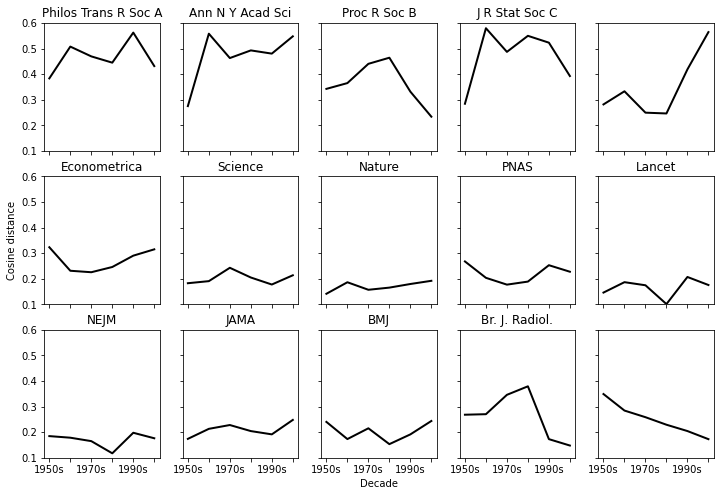

In [270]:
def plot_venue_semantic_change(save=False):
    """"""
    venues = [('Philosophical Transactions of the Royal Society A', 'Philos Trans R Soc A'), 
              ('Annals of the New York Academy of Sciences', 'Ann N Y Acad Sci'), 
              ('Proceedings of The Royal Society B: Biological Sciences', 'Proc R Soc B'), 
              ('Journal of The Royal Statistical Society Series C-applied Statistics', 'J R Stat Soc C'), 
              ('The American review of respiratory disease', ''), 
              ('Econometrica', 'Econometrica'), 
              ('Science', 'Science'), 
              ('Nature', 'Nature'), 
              ('Proceedings of the National Academy of Sciences of the United States of America', 'PNAS'),
              ('The Lancet', 'Lancet'), 
              ('The New England Journal of Medicine', 'NEJM'), 
              ('JAMA', 'JAMA'), 
              ('BMJ', 'BMJ'), 
              ('British Journal of Radiology', 'Br. J. Radiol.'), 
              ('American Journal of Public Health', ''), 
              ('Angewandte Chemie', 'Angewandte Chemie'), 
              ('Bioinformatics', 'Bioinformatics'), 
              ('Science of The Total Environment', ''), 
              ('Management Science', 'Management Science'), 
              ('Journal of Biological Chemistry', 'JBC'), 
              ('The Journal of Infectious Diseases', ''), 
              ('Journal of Chemical Information and Modeling', ''), 
              ('meeting of the association for computational linguistics', 'ACL'), 
              ('Physical Review Letters', 'PRL'), 
              ('Physical Review D', 'PRD'), 
              ('The Astrophysical Journal', ''),
              ('Journal of the American Chemical Society', '')
             ]
    cols = ['cos_dist_1950s', 'cos_dist_1960s', 'cos_dist_1970s', 'cos_dist_1980s', 'cos_dist_1990s', 'cos_dist_2000s']
    fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(12,8))
    for (v, vb), ax in zip(venues, axes.flatten()):
        vid_dist_df[vid_dist_df.name == v].iloc[0][cols].plot(ax=ax, color='k', ylim=[.1, .6], lw=2, xticks=range(0,6))
        ax.set_title(vb)
    for i in range(5):
        axes[2,i].set(xticklabels=['1950s', '', '1970s', '', '1990s', ''])
    axes[2,2].set(xlabel='Decade')
    axes[1,0].set(ylabel='Cosine distance')
    if save:
        plt.savefig('../figs/journal_dist_align.pdf', bbox_inches='tight')

plot_venue_semantic_change()

In [113]:
vid_dist_df[][['max_dist', 'total_dist']].corr(method='spearman')

,max_dist,total_dist
max_dist,1.000000,0.652804
total_dist,0.652804,1.000000


In [115]:
vid_dist_df[vid_dist_df.cos_dist_1950s.notna()][['total_dist', 'max_dist']].corr(method='spearman')

,total_dist,max_dist
total_dist,1.000000,0.759546
max_dist,0.759546,1.000000


<AxesSubplot: ylabel='Frequency'>

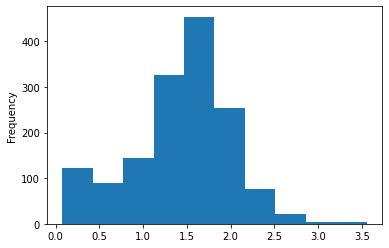

In [92]:
vid_dist_df[vid_dist_df.cos_dist_1950s.notna()].sort_values('total', ascending=False).total.plot.hist()

In [118]:
 pd.wide_to_long(vid_dist_df,
                             stubnames=['neighbor_distance'],
                             suffix='.+',
                             sep='_',
                             i = ['vid', 'name'],
                             j = 'decade')

TypeError: wide_to_long() missing 1 required positional argument: 'j'